In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import colormaps 
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from collections import Counter
from semanticscholar import SemanticScholar
from urllib.parse import urlparse
import copy
from matplotlib_venn import venn2, venn2_circles
import os

In [2]:
client = bigquery.Client(project='subugoe-wag-closed')

In [3]:
s2ag_papers = 'subugoe-wag-closed.S2AG.papers_2023_05_23'
upw_snapshot = 'subugoe-collaborative.upw_instant.snapshot'
openalex_snapshot = 'subugoe-collaborative.openalex.works'
crossref_snapshot = 'subugoe-collaborative.cr_history.cr_apr23'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

Paratext-Liste: https://github.com/subugoe/oam_by_the_numbers/blob/main/inst/sql/oam_jn_disambiguate.sql

## Abdeckung von DOIs

In [5]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(externalids.DOI)) AS number_of_dois, 
                              COUNT(DISTINCT(corpusid)) AS number_of_publications, 
                              EXTRACT (YEAR FROM publicationdate) AS year
                       FROM {s2ag_papers} 
                       GROUP BY year
                       ORDER BY year DESC
                       """).to_dataframe()

In [6]:
df_doi['number_of_dois'].sum()

116545907

In [7]:
df_doi['number_of_publications'].sum()

212251613

In [8]:
df_doi['number_of_dois'].sum()/df_doi['number_of_publications'].sum()

0.549093151061236

In [9]:
df_doi_2000 = df_doi[(df_doi.year >= 2000) & (df_doi.year < 2023)]

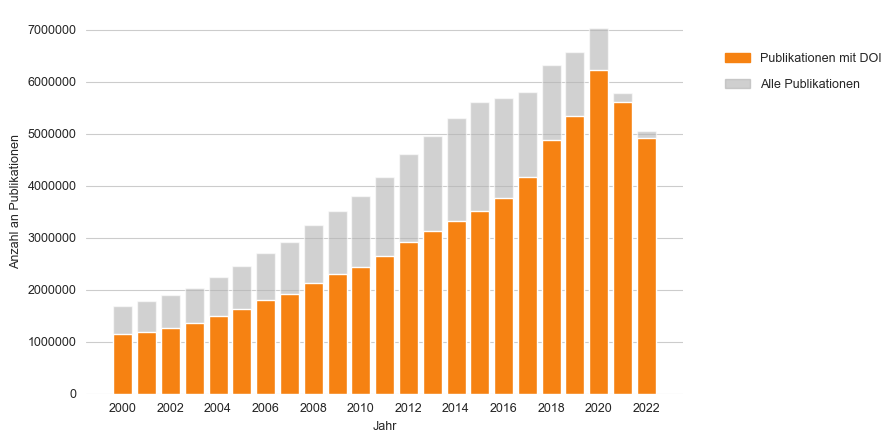

In [10]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            ci=None)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_dois', 
            alpha=1,
            color='#f68212',
            saturation=1,
            ci=None)

plt.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

doi_patch = mpatches.Patch(color='#f68212', label='Publikationen mit DOI')
not_doi_patch = mpatches.Patch(color='#b3b3b3a0', label='Alle Publikationen')

lgd = fig.legend(handles=[doi_patch, not_doi_patch], frameon=False,
                 bbox_to_anchor=(1.28, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/doi.png', format='png', bbox_inches='tight', dpi=500)

## Abdeckung von Publikationstypen

In [9]:
df_types_single = client.query(f"""
                                SELECT type, MIN(year) AS span_min, MAX(year) AS span_max, 
                                       COUNT(DISTINCT(corpusid)) AS number_of_publications
                                FROM (
                                     SELECT DISTINCT type, corpusid, EXTRACT (YEAR FROM publicationdate) AS year
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                     )
                                GROUP BY type
                                """).to_dataframe()

In [10]:
df_types_single

,type,span_min,span_max,number_of_publications
0,JournalArticle,1708,2023,40653847
1,ClinicalTrial,1901,2023,582242
2,Review,1708,2023,14816489
3,Conference,1754,2023,3925269
4,Editorial,1812,2023,668952
5,MetaAnalysis,1966,2023,103713
6,LettersAndComments,1817,2023,1547956
7,News,1781,2023,240329
8,CaseReport,1838,2023,2190491
9,Study,1893,2023,2341460


In [29]:
df_types_agg = client.query(f"""
                             SELECT ARRAY_TO_STRING(publicationtypes, ",") AS types, 
                                    COUNT(DISTINCT(corpusid)) AS number_of_publications
                             FROM {s2ag_papers}
                             GROUP BY types
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [30]:
df_types_agg

,types,number_of_publications
0,,157938099
1,JournalArticle,29349229
2,Review,8859835
3,"Review,JournalArticle",2681734
4,"JournalArticle,Review",2305552
...,...,...
623,"JournalArticle,Study,Review,Book,LettersAndCom...",1
624,"Editorial,Book,Review",1
625,"CaseReport,MetaAnalysis,JournalArticle",1
626,"News,Editorial,JournalArticle,Review",1


In [31]:
df_types_agg.head(10)

,types,number_of_publications
0,,157938099
1,JournalArticle,29349229
2,Review,8859835
3,"Review,JournalArticle",2681734
4,"JournalArticle,Review",2305552
5,Conference,2304740
6,"JournalArticle,Study",1581946
7,"JournalArticle,CaseReport",1485954
8,"JournalArticle,Conference",1337878
9,LettersAndComments,857292


In [32]:
df_types_agg['types'] = df_types_agg['types'].apply(lambda x: x.split(','))

In [33]:
types_dict_count = Counter(
    Dataset=0,
    MetaAnalysis=0,
    Book=0,
    News=0,
    Conference=0,
    LettersAndComments=0,
    ClinicalTrial=0,
    Editorial=0,
    JournalArticle=0,
    Study=0,
    CaseReport=0,
    Review=0
)

In [34]:
types_dict = dict(
    Dataset=copy.copy(types_dict_count),
    MetaAnalysis=copy.copy(types_dict_count),
    Book=copy.copy(types_dict_count),
    News=copy.copy(types_dict_count),
    Conference=copy.copy(types_dict_count),
    LettersAndComments=copy.copy(types_dict_count),
    ClinicalTrial=copy.copy(types_dict_count),
    Editorial=copy.copy(types_dict_count),
    JournalArticle=copy.copy(types_dict_count),
    Study=copy.copy(types_dict_count),
    CaseReport=copy.copy(types_dict_count),
    Review=copy.copy(types_dict_count)
    
)

In [35]:
def count_combinations(type_combination: list, number_of_publications: int):
    for t in type_combination:
        if t == '':
            continue
        d = types_dict[t]
        for t_count in d:
            for t2 in type_combination:
                if t2 == t_count:
                    d[t_count] += number_of_publications

In [36]:
for row in df_types_agg.to_dict('records'):
    count_combinations(row['types'], row['number_of_publications'])

In [37]:
types_dict['Dataset '] = types_dict.pop('Dataset')
types_dict['MetaAnalysis '] = types_dict.pop('MetaAnalysis')
types_dict['Book '] = types_dict.pop('Book')
types_dict['News '] = types_dict.pop('News')
types_dict['Conference '] = types_dict.pop('Conference')
types_dict['LettersAndComments '] = types_dict.pop('LettersAndComments')
types_dict['ClinicalTrial '] = types_dict.pop('ClinicalTrial')
types_dict['Editorial '] = types_dict.pop('Editorial')
types_dict['JournalArticle '] = types_dict.pop('JournalArticle')
types_dict['Study '] = types_dict.pop('Study')
types_dict['CaseReport '] = types_dict.pop('CaseReport')
types_dict['Review '] = types_dict.pop('Review')

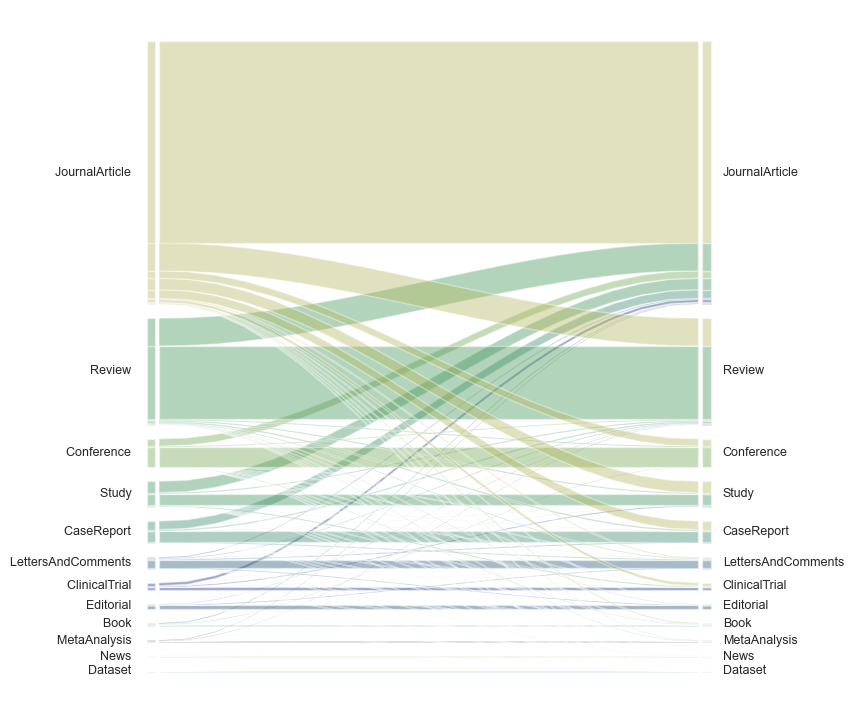

In [46]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(types_dict, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(8,9)
plt.show()
fig.savefig('media/alluvial.png', format='png', bbox_inches='tight', dpi=500)

## Publikationstyp nach Fachgebiet

In [47]:
df_type_fields = client.query(f"""
                               SELECT category, type, COUNT(DISTINCT(corpusid)) AS number_of_publications
                               FROM (
                                  SELECT DISTINCT type, field.category AS category, corpusid
                                  FROM {s2ag_papers}, UNNEST(publicationtypes) as type, 
                                       UNNEST(s2fieldsofstudy) as field 
                               )
                               GROUP BY category, type
                               ORDER BY number_of_publications DESC
                               """).to_dataframe()

In [48]:
df_type_fields_sum = df_type_fields.groupby(['category'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False)
df_type_fields_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_type_fields = pd.merge(df_type_fields_sum, df_type_fields, on=['category'])

In [49]:
df_type_fields['proportion'] = (df_type_fields['number_of_publications'])/\
                                        (df_type_fields['number_of_total_publications']) * 100

df_type_fields['proportion'] = df_type_fields['proportion'].apply(lambda x: '{0:.1f}'.format(x))

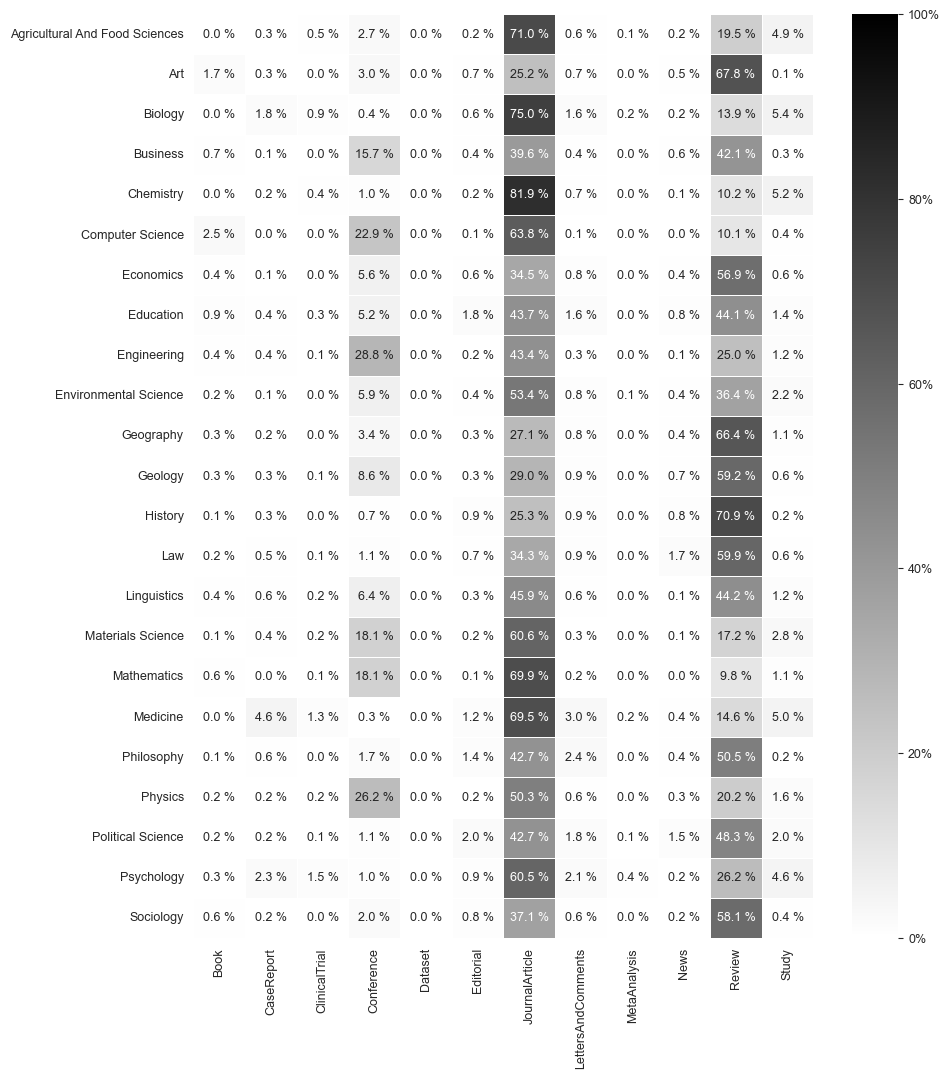

In [50]:
df_type_fields_heatmap = pd.pivot_table(df_type_fields, 
                                        index='category', 
                                        columns='type', 
                                        values='proportion', 
                                        fill_value=float(0))

fig, ax = plt.subplots(figsize=(10, 12))
ax1 = sns.heatmap(df_type_fields_heatmap, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.ylabel('')
plt.xlabel('')
plt.show()
fig.savefig('media/category_field.png', format='png', bbox_inches='tight', dpi=500)

## Publikationstyp nach Venue

In [51]:
df_venue = client.query(f"""
                         SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_total_publications
                         FROM {s2ag_papers}
                         GROUP BY venue
                         ORDER BY number_of_total_publications DESC
                         LIMIT 20
                         """).to_dataframe()

In [52]:
df_venue

,venue,number_of_total_publications
0,,144654469
1,Nature,422845
2,PLoS ONE,277864
3,Science,273448
4,Scientific Reports,242112
5,British medical journal,235921
6,Social Science Research Network,233853
7,arXiv.org,227557
8,Journal of Biological Chemistry,192124
9,The Lancet,179138


## Abdeckung nach Fachgebieten

In [53]:
df_fields = client.query(f"""
                          SELECT category, 
                                 COUNT(DISTINCT(corpusid)) AS number_of_publications
                          FROM (
                              SELECT DISTINCT corpusid, field.category AS category
                              FROM {s2ag_papers}, UNNEST(s2fieldsofstudy) as field 
                          )
                          GROUP BY category
                          ORDER BY number_of_publications DESC
                          """).to_dataframe()

In [54]:
df_fields['number_of_total_publications'] = df_fields['number_of_publications'].sum()
df_fields['proportion'] = (df_fields['number_of_publications']/df_fields['number_of_total_publications']) * 100
df_fields['proportion'] = df_fields['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [55]:
df_fields

,category,number_of_publications,number_of_total_publications,proportion
0,Medicine,49239928,222012842,22.18
1,Biology,24002714,222012842,10.81
2,Chemistry,15728971,222012842,7.08
3,Computer Science,15395754,222012842,6.93
4,Engineering,14310854,222012842,6.45
5,Physics,13248713,222012842,5.97
6,Materials Science,12467378,222012842,5.62
7,Psychology,9983589,222012842,4.50
8,Environmental Science,7348149,222012842,3.31
9,Business,7196264,222012842,3.24


In [56]:
df_fields.proportion.apply(lambda x: float(x)).sum()

100.00999999999999

In [57]:
#SELECT DISTINCT STRING_AGG(fields.category, ",")
#FROM `subugoe-wag-closed.S2AG.papers`, UNNEST(s2fieldsofstudy) AS fields 
#WHERE corpusid = 234301870

## Open Access Anteil Zeitschriften

In [45]:
df_oa = client.query(f"""
                      SELECT isopenaccess, year, COUNT(DISTINCT(corpusid)) AS number_of_publications,
                             COUNT(DISTINCT(doi)) AS number_of_dois
                      FROM (
                          SELECT DISTINCT corpusid, externalids.DOI as doi, 
                                 isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                          FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                          WHERE type = "JournalArticle" AND year >= 2000 AND year < 2023
                              AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                          )
                      WHERE year IS NOT NULL
                      GROUP BY isopenaccess, year
                      """).to_dataframe()

In [46]:
df_oa_total_year = df_oa.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_total_year.rename(columns={'number_of_publications':'number_of_total_publications'}, inplace=True)
df_oa = pd.merge(df_oa, df_oa_total_year, on='year')

In [47]:
df_oa_doi_prop = df_oa.groupby(['year'])['number_of_dois'].sum().reset_index()
df_oa_doi_prop = pd.merge(df_oa_doi_prop, df_oa[['year', 'number_of_total_publications']], on='year')
df_oa_doi_prop.rename(columns={'number_of_dois':'number_of_total_dois'}, inplace=True)
df_oa_doi_prop['doi_prop'] = (df_oa_doi_prop['number_of_total_dois']/\
                                df_oa_doi_prop['number_of_total_publications']) * 100
df_oa_doi_prop['doi_prop'] = df_oa_doi_prop['doi_prop'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_doi_prop.drop_duplicates()

,year,number_of_total_dois,number_of_total_publications,doi_prop
0,2000,401908,461125,87.16
2,2001,421226,476759,88.35
4,2002,449524,510374,88.08
6,2003,482997,542459,89.04
8,2004,534993,593533,90.14
10,2005,583136,642982,90.69
12,2006,638891,697950,91.54
14,2007,670161,731453,91.62
16,2008,724973,783500,92.53
18,2009,808218,864539,93.49


In [48]:
df_oa = pd.merge(df_oa, df_oa_doi_prop[['year', 'number_of_total_dois']], on='year')

In [49]:
df_oa_prop = df_oa.copy()
df_oa_prop.drop_duplicates(inplace=True)
df_oa_prop['oa_prop'] = (df_oa_prop['number_of_publications'] / df_oa_prop['number_of_total_publications']) * 100
df_oa_prop['oa_prop'] = df_oa_prop['oa_prop'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_prop[df_oa_prop.isopenaccess==True].sort_values(by=['year'], ascending=True)

,isopenaccess,year,number_of_publications,number_of_dois,number_of_total_publications,number_of_total_dois,oa_prop
60,True,2000,116401,116400,461125,401908,25.24
76,True,2001,126421,126420,476759,421226,26.52
40,True,2002,139311,139306,510374,449524,27.30
10,True,2003,153535,153533,542459,482997,28.30
70,True,2004,173951,173947,593533,534993,29.31
72,True,2005,195437,195422,642982,583136,30.40
30,True,2006,214852,214848,697950,638891,30.78
0,True,2007,232156,232137,731453,670161,31.74
20,True,2008,264494,264475,783500,724973,33.76
66,True,2009,303497,303481,864539,808218,35.11


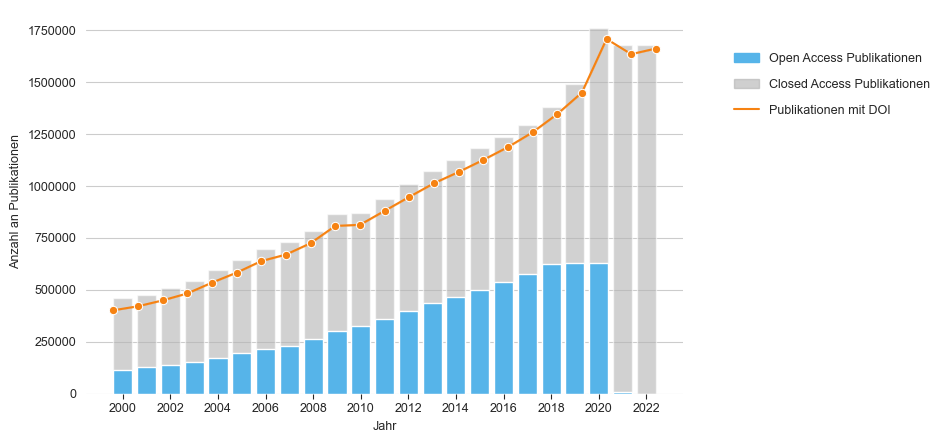

In [50]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_oa, 
            x='year', 
            y='number_of_total_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            ax=ax,
            ci=None)

sns.barplot(data=df_oa[df_oa.isopenaccess==True], 
            x='year', 
            y='number_of_publications', 
            alpha=1,
            color='#56B4E9',
            saturation=1,
            ax=ax,
            ci=None)

ax2 = ax.twiny()

sns.lineplot(data=df_oa,
             x='year',
             y='number_of_total_dois',
             color='#f68212',
             marker='o',
             ax=ax2)

ax.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.grid(False, which='both', axis='x')
ax2.set(xticklabels=[], xlabel=None)
ax2.tick_params(top=False)
ax2.set(xticks=list(range(2000, 2023, 2)))
#ax2.get_legend().remove()

plt.box(False)

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

oa_patch = mpatches.Patch(color='#56B4E9', label='Open Access Publikationen')
not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='Closed Access Publikationen')
doi_patch = Line2D([0], [0], color='#f68212', label='Publikationen mit DOI')

lgd = fig.legend(handles=[oa_patch, not_oa_patch, doi_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_pub.png', format='png', bbox_inches='tight', dpi=500)

## Open Access nach Verlag

In [64]:
df_oa_id = client.query(f"""
                         SELECT isopenaccess, COUNT(DISTINCT(corpusid)) AS number_of_publications
                         FROM (
                             SELECT DISTINCT corpusid, isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                             FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                             WHERE type = "JournalArticle" AND year >= 2008 AND year < 2021
                                 AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                             )
                         WHERE year IS NOT NULL
                         GROUP BY isopenaccess
                         ORDER BY number_of_publications DESC
                         """).to_dataframe()

In [65]:
df_oa_doi = client.query(f"""
                          SELECT isopenaccess, COUNT(DISTINCT(doi)) AS number_of_publications
                          FROM (
                              SELECT DISTINCT externalids.DOI as doi, 
                                     isopenaccess, EXTRACT (YEAR FROM publicationdate) AS year
                              FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                              WHERE type = "JournalArticle" AND year >= 2008 AND year < 2021
                                  AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                              )
                          WHERE year IS NOT NULL
                          GROUP BY isopenaccess
                          ORDER BY number_of_publications DESC
                          """).to_dataframe()

In [66]:
df_oa_id['number_of_total_publications'] = df_oa_id['number_of_publications'].sum()
df_oa_id['proportion'] = (df_oa_id['number_of_publications'])/(df_oa_id['number_of_total_publications']) * 100
df_oa_id['proportion'] = df_oa_id['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [67]:
df_oa_id

,isopenaccess,number_of_publications,number_of_total_publications,proportion
0,False,8959150,15013553,59.67
1,True,6054403,15013553,40.33


In [68]:
df_oa_doi['number_of_total_publications'] = df_oa_doi['number_of_publications'].sum()
df_oa_doi['proportion'] = (df_oa_doi['number_of_publications'])/(df_oa_doi['number_of_total_publications']) * 100
df_oa_doi['proportion'] = df_oa_doi['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [69]:
df_oa_doi

,isopenaccess,number_of_publications,number_of_total_publications,proportion
0,False,8279691,14333157,57.77
1,True,6053466,14333157,42.23


In [71]:
df_oa_id.number_of_total_publications.iloc[0] - df_oa_doi.number_of_total_publications.iloc[0]

680396

In [72]:
(680396 / df_oa_id.number_of_total_publications.iloc[0]) * 100

4.531878629928572

In [73]:
df_oa_upw_coverage = client.query(f"""
                                   SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications, 
                                   FROM (
                                       SELECT DISTINCT externalids.DOI as doi,
                                              EXTRACT (YEAR FROM publicationdate) AS year
                                       FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                       WHERE type = "JournalArticle" AND year >= 2008 AND year < 2021
                                           AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')

                                       ) AS s2ag
                                   INNER JOIN {upw_snapshot} AS upw
                                   ON LOWER(s2ag.doi) = LOWER(upw.doi)
                                   WHERE s2ag.year IS NOT NULL
                                   """).to_dataframe()

In [74]:
df_oa_upw_coverage

,number_of_publications
0,14033976


In [270]:
14033976/15013553

0.934753818766284

In [75]:
(14033976 / df_oa_id.number_of_total_publications.iloc[0]) * 100

93.4753818766284

In [5]:
df_oa_doi_publisher = client.query(f"""
                                   SELECT DISTINCT SUM(DISTINCT number_of_publications) AS number_of_publications, isopenaccess, publisher
                                    FROM (
                                      SELECT SPLIT(cr.issn, ",") AS cr_issn, cr.publisher AS publisher, number_of_publications, isopenaccess
                                      FROM (
                                        SELECT COUNT(DISTINCT(externalids.DOI)) AS number_of_publications, isopenaccess, s2_venues.issn AS s2_issn
                                        FROM `subugoe-wag-closed.S2AG.papers_2023_05_23` AS s2_papers, UNNEST(publicationtypes) as s2_papers_type
                                        INNER JOIN `subugoe-wag-closed.S2AG.venues_2023_05_23` AS s2_venues
                                        ON s2_papers.publicationvenueid = s2_venues.id
                                        WHERE s2_papers_type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                          AND NOT REGEXP_CONTAINS(s2_papers.title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                        GROUP BY isopenaccess, s2_issn
                                      ) AS s2
                                      INNER JOIN `subugoe-collaborative.cr_history.cr_apr23` AS cr
                                      ON cr.issn = s2_issn
                                    )
                                    GROUP BY publisher, isopenaccess
                                    ORDER BY number_of_publications DESC
                                   """).to_dataframe()

In [6]:
df_oa_doi_publisher.publisher.nunique()

1793

In [7]:
df_oa_doi_publisher_total = df_oa_doi_publisher.groupby(['publisher'])['number_of_publications']\
                                        .sum().reset_index()
df_oa_doi_publisher_total.rename(columns={'number_of_publications':'number_of_total_publications'}, inplace=True)
df_oa_doi_publisher = pd.merge(df_oa_doi_publisher, df_oa_doi_publisher_total, on='publisher')

In [8]:
df_oa_doi_publisher['proportion'] = df_oa_doi_publisher['number_of_publications']/\
                                        df_oa_doi_publisher['number_of_total_publications']

In [39]:
df_oa_doi_publisher[(df_oa_doi_publisher.proportion > 0) & (df_oa_doi_publisher.isopenaccess==True)].proportion.mean()

0.6743219368383326

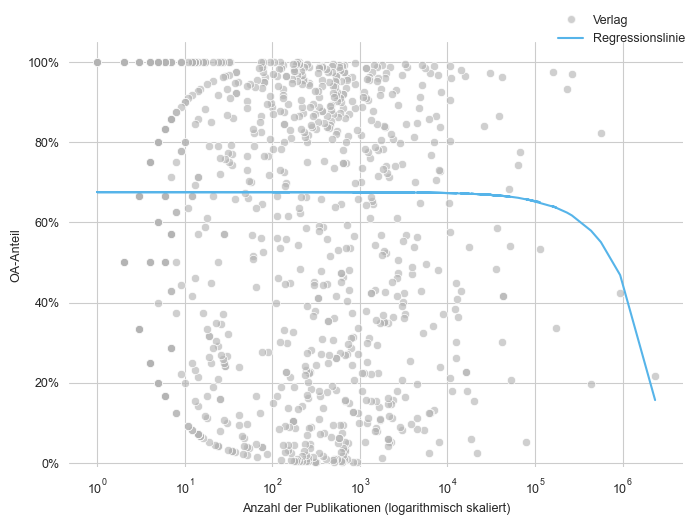

In [9]:
df_publisher_scatter = df_oa_doi_publisher[df_oa_doi_publisher.isopenaccess==True].copy()

x = df_publisher_scatter['number_of_total_publications'].tolist()
y = df_publisher_scatter['proportion'].tolist()

fig, ax = plt.subplots(figsize=(7,5))

plt.box(False)

sns.scatterplot(data=df_publisher_scatter, 
                x='number_of_total_publications', 
                y='proportion',
                color='#b3b3b3a0')

m, b = np.polyfit(x, y, 1)

plt.plot(x, [m * i for i in x] + b, color='#56B4E9')

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xscale('log')
ax.set_ylim(-0.01, 1.05)
plt.xlabel('Anzahl der Publikationen (logarithmisch skaliert)')
plt.ylabel('OA-Anteil')

publisher_patch = Line2D([], [], marker='o', markerfacecolor='#b3b3b3a0', color='white', label='Verlag')
reg_line_patch = Line2D([0], [0], color='#56B4E9', label='Regressionslinie')

lgd = fig.legend(handles=[publisher_patch, reg_line_patch], 
                 frameon=False, bbox_to_anchor=(1, 1.05))

plt.tight_layout()
plt.show()
fig.savefig('media/publisher_distribution.png', format='png', bbox_inches='tight', dpi=500)

In [10]:
df_oa_doi_publisher_total.sort_values(by=['number_of_total_publications'], ascending=False).head(20)

,publisher,number_of_total_publications
455,Elsevier BV,2354894
1762,Wiley,938952
1436,Springer Science and Business Media LLC,565917
1143,Ovid Technologies (Wolters Kluwer Health),436826
958,MDPI AG,264089
1224,Public Library of Science (PLoS),232331
687,Institute of Electrical and Electronics Engine...,174227
534,Frontiers Media SA,158632
1144,Oxford University Press (OUP),113967
1020,Medknow,79427


In [11]:
df_oa_doi_publisher_hist = pd.merge(df_oa_doi_publisher, 
                                    df_oa_doi_publisher_total.sort_values(by=['number_of_total_publications'], 
                                                          ascending=False).head(20)[['publisher']])

In [12]:
df_oa_doi_publisher_hist2 = pd.merge(df_oa_doi_publisher, 
                                     df_oa_doi_publisher_total.sort_values(by=['number_of_total_publications'], 
                                                          ascending=False).head(20)[['publisher']],
                                     how='outer', indicator=True)

In [13]:
df_oa_doi_publisher_hist2 = df_oa_doi_publisher_hist2.loc[df_oa_doi_publisher_hist2._merge == 'left_only'].copy()
df_oa_doi_publisher_hist2 = df_oa_doi_publisher_hist2.groupby(['isopenaccess'])['number_of_publications']\
                                .sum().reset_index()
df_oa_doi_publisher_hist2['number_of_total_publications'] = df_oa_doi_publisher_hist2['number_of_publications']\
                                                                            .sum()
df_oa_doi_publisher_hist2['publisher'] = 'Other'
df_oa_doi_publisher_hist2['proportion'] = df_oa_doi_publisher_hist2['number_of_publications']/\
                                            df_oa_doi_publisher_hist2['number_of_total_publications']

In [14]:
df_oa_doi_publisher_hist = pd.concat([df_oa_doi_publisher_hist, df_oa_doi_publisher_hist2], ignore_index=True)
df_oa_doi_publisher_hist['pub_prop'] = df_oa_doi_publisher_hist['number_of_total_publications']/\
                                            df_oa_doi_publisher_hist['number_of_publications'].sum()

In [15]:
df_oa_doi_publisher_hist

,number_of_publications,isopenaccess,publisher,number_of_total_publications,proportion,pub_prop
0,1843875,False,Elsevier BV,2354894,0.782997,0.340256
1,511019,True,Elsevier BV,2354894,0.217003,0.340256
2,540462,False,Wiley,938952,0.575601,0.135668
3,398490,True,Wiley,938952,0.424399,0.135668
4,465921,True,Springer Science and Business Media LLC,565917,0.823303,0.081769
5,99996,False,Springer Science and Business Media LLC,565917,0.176697,0.081769
6,351210,False,Ovid Technologies (Wolters Kluwer Health),436826,0.804004,0.063116
7,85616,True,Ovid Technologies (Wolters Kluwer Health),436826,0.195996,0.063116
8,256130,True,MDPI AG,264089,0.969862,0.038158
9,7959,False,MDPI AG,264089,0.030138,0.038158


In [74]:
df_oa_doi_publisher_hist.number_of_total_publications.sum()

13841906

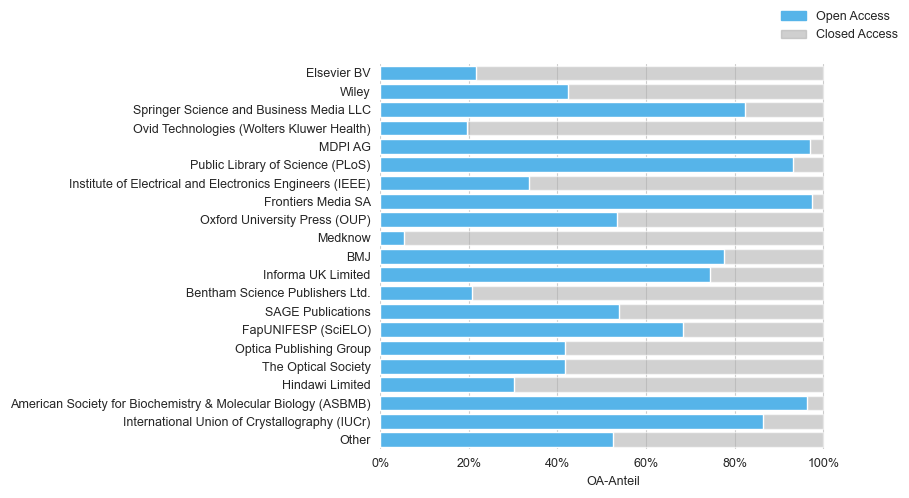

In [92]:
fig, axes = plt.subplots(figsize=(6,5))

plot_df_publisher = pd.concat([df_oa_doi_publisher_hist[(df_oa_doi_publisher_hist.isopenaccess == True) \
                        & (df_oa_doi_publisher_hist.publisher != 'Other')]\
                        .sort_values(by=['number_of_total_publications'], ascending=False), 
                        df_oa_doi_publisher_hist[(df_oa_doi_publisher_hist.isopenaccess == True) \
                        & (df_oa_doi_publisher_hist.publisher == 'Other')]], ignore_index=True)

plt.box(False)

ax1 = sns.barplot(x=[1] * len(df_oa_doi_publisher_hist), 
                  y='publisher', 
                  data=df_oa_doi_publisher_hist, 
                  label='FALSE', 
                  color='#b3b3b3a0',
                  saturation=1,
                  alpha=0.6
                 )

ax2 = sns.barplot(x='proportion', 
                  y='publisher', 
                  data=plot_df_publisher, 
                  label='TRUE', 
                  color='#56B4E9',
                  saturation=1,
                  alpha=1
                 )

plt.xlabel('OA-Anteil')
plt.ylabel('')

oa_patch = mpatches.Patch(color='#56B4E9', label='Open Access')
not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='Closed Access')

lgd = fig.legend(handles=[oa_patch, not_oa_patch], frameon=False, loc='upper right')

axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()
fig.savefig('media/oa_status_publisher.png', format='png', bbox_inches='tight', dpi=500)

## Unpaywall

In [5]:
df_oa_status = client.query(f"""
                             SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications, 
                                    s2ag.year as year,
                                    upw.is_oa as upw_oa_status, s2ag.isopenaccess as s2_oa_status
                             FROM (
                                 SELECT DISTINCT externalids.DOI as doi, isopenaccess,
                                        EXTRACT (YEAR FROM publicationdate) AS year
                                 FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                 WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                     AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                 ) AS s2ag
                             INNER JOIN {upw_snapshot} AS upw
                             ON LOWER(s2ag.doi) = LOWER(upw.doi)
                             WHERE s2ag.year IS NOT NULL
                             GROUP BY year, upw_oa_status, s2_oa_status
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [6]:
df_oa_status_upw = df_oa_status.groupby(['upw_oa_status', 'year'])['number_of_publications'].sum().reset_index()
df_oa_status_s2 = df_oa_status.groupby(['s2_oa_status', 'year'])['number_of_publications'].sum().reset_index()

In [7]:
df_oa_status_upw_total = df_oa_status_upw.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_status_upw_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_status_upw = pd.merge(df_oa_status_upw, df_oa_status_upw_total, on='year')
df_oa_status_upw['proportion'] = (df_oa_status_upw['number_of_publications']/\
                                  df_oa_status_upw['number_of_total_publications']) * 100
#df_oa_status_upw['proportion'] = df_oa_status_upw['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_status_upw.drop_duplicates()

,upw_oa_status,year,number_of_publications,number_of_total_publications,proportion
0,False,2008,442592,684724,64.638015
1,True,2008,242132,684724,35.361985
2,False,2009,503940,793276,63.52644
3,True,2009,289336,793276,36.47356
4,False,2010,484035,800026,60.502409
5,True,2010,315991,800026,39.497591
6,False,2011,513178,866860,59.19964
7,True,2011,353682,866860,40.80036
8,False,2012,535632,932889,57.416477
9,True,2012,397257,932889,42.583523


In [8]:
df_oa_status_upw[df_oa_status_upw.upw_oa_status==True].proportion.mean()

46.46110320362187

In [9]:
df_oa_status_s2_total = df_oa_status_s2.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_status_s2_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_status_s2 = pd.merge(df_oa_status_s2, df_oa_status_s2_total, on='year')
df_oa_status_s2['proportion'] = (df_oa_status_s2['number_of_publications']/\
                                 df_oa_status_s2['number_of_total_publications']) * 100
#df_oa_status_s2['proportion'] = df_oa_status_s2['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_status_s2.drop_duplicates()

,s2_oa_status,year,number_of_publications,number_of_total_publications,proportion
0,False,2008,431141,684724,62.965662
1,True,2008,253583,684724,37.034338
2,False,2009,491048,793276,61.90128
3,True,2009,302228,793276,38.09872
4,False,2010,475595,800026,59.447443
5,True,2010,324431,800026,40.552557
6,False,2011,506139,866860,58.387629
7,True,2011,360721,866860,41.612371
8,False,2012,533712,932889,57.210665
9,True,2012,399177,932889,42.789335


In [10]:
np.corrcoef(df_oa_status_s2.proportion.tolist(), 
            df_oa_status_upw.proportion.tolist())

array([[1.        , 0.61747222],
       [0.61747222, 1.        ]])

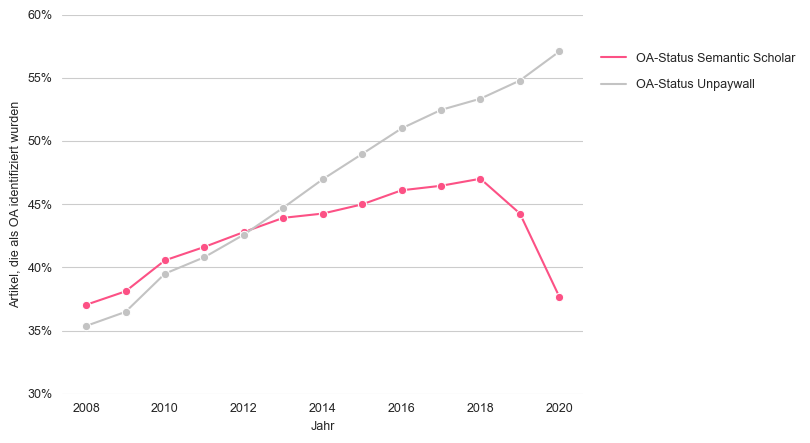

In [51]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=df_oa_status_s2[df_oa_status_s2.s2_oa_status == True],
             x='year',
             y='proportion',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oa_status_upw[df_oa_status_upw.upw_oa_status == True],
             x='year',
             y='proportion',
             color='#c3c3c3',
             marker='o',
             ax=ax)

xticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(xticks)
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Artikel, die als OA identifiziert wurden')

s2_patch = Line2D([0], [0], color='#fc5185', label='OA-Status Semantic Scholar')
upw_patch = Line2D([0], [0], color='#c3c3c3', label='OA-Status Unpaywall')

lgd = fig.legend(handles=[s2_patch, upw_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.ylim(30, 60)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_upw_s2.png', format='png', bbox_inches='tight', dpi=500)

## OA-Status nach Disziplin

In [14]:
df_oa_disc = client.query(f"""
                           SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications, 
                                  s2ag.year as year, s2ag.category,
                                  upw.is_oa as upw_oa_status, s2ag.isopenaccess as s2_oa_status
                           FROM (
                               SELECT DISTINCT externalids.DOI as doi, isopenaccess,
                                      EXTRACT (YEAR FROM publicationdate) AS year,
                                      field.category AS category
                               FROM {s2ag_papers}, UNNEST(publicationtypes) as type,
                                   UNNEST(s2fieldsofstudy) as field 
                               WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                   AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                               ) AS s2ag
                           INNER JOIN {upw_snapshot} AS upw
                           ON LOWER(s2ag.doi) = LOWER(upw.doi)
                           WHERE s2ag.year IS NOT NULL
                           GROUP BY year, category, upw_oa_status, s2_oa_status
                           ORDER BY category, number_of_publications DESC
                           """).to_dataframe()

In [15]:
df_oa_disc

,number_of_publications,year,category,upw_oa_status,s2_oa_status
0,23300,2020,Agricultural And Food Sciences,True,True
1,22102,2020,Agricultural And Food Sciences,False,False
2,20720,2019,Agricultural And Food Sciences,True,True
3,19318,2019,Agricultural And Food Sciences,False,False
4,17396,2018,Agricultural And Food Sciences,True,True
...,...,...,...,...,...
1191,447,2012,Sociology,True,False
1192,342,2011,Sociology,True,False
1193,313,2010,Sociology,True,False
1194,256,2008,Sociology,True,False


In [16]:
df_oa_disc_upw = df_oa_disc.groupby(['upw_oa_status', 'year', 'category'])['number_of_publications']\
                        .sum().reset_index()
df_oa_disc_s2 = df_oa_disc.groupby(['s2_oa_status', 'year', 'category'])['number_of_publications']\
                        .sum().reset_index()

In [17]:
df_oa_disc_upw_total = df_oa_disc_upw.groupby(['year', 'category'])['number_of_publications'].sum().reset_index()
df_oa_disc_upw_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_disc_upw = pd.merge(df_oa_disc_upw, df_oa_disc_upw_total, on=['year', 'category'])
df_oa_disc_upw['proportion'] = (df_oa_disc_upw['number_of_publications']/\
                                df_oa_disc_upw['number_of_total_publications']) * 100

In [18]:
df_oa_disc_s2_total = df_oa_disc_s2.groupby(['year', 'category'])['number_of_publications'].sum().reset_index()
df_oa_disc_s2_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_disc_s2 = pd.merge(df_oa_disc_s2, df_oa_disc_s2_total, on=['year', 'category'])
df_oa_disc_s2['proportion'] = (df_oa_disc_s2['number_of_publications']/\
                               df_oa_disc_s2['number_of_total_publications']) * 100

In [19]:
df_oa_disc_upw_table = df_oa_disc_upw.groupby(['category', 'upw_oa_status'])['number_of_publications']\
                        .sum().reset_index()
df_oa_disc_upw_table['number_of_total_publications'] = df_oa_disc_upw_table['number_of_publications'].sum()
df_oa_disc_upw_table_total = df_oa_disc_upw_table.groupby(['category'])['number_of_publications'].sum()\
                                .reset_index()
df_oa_disc_upw_table_total.rename(columns={'number_of_publications': 'number_of_total_cat_publications'}, 
                                  inplace=True)
df_oa_disc_upw_table = pd.merge(df_oa_disc_upw_table, df_oa_disc_upw_table_total, on=['category'])
df_oa_disc_upw_table['oa_proportion'] = (df_oa_disc_upw_table['number_of_publications']/\
                                         df_oa_disc_upw_table['number_of_total_cat_publications']) * 100
df_oa_disc_upw_table['proportion'] = (df_oa_disc_upw_table['number_of_total_cat_publications']/\
                                      df_oa_disc_upw_table['number_of_total_publications']) * 100
df_oa_disc_upw_table['proportion'] = df_oa_disc_upw_table['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_disc_upw_table['oa_proportion'] = df_oa_disc_upw_table['oa_proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_disc_upw_table[df_oa_disc_upw_table.upw_oa_status==True].sort_values(by=['number_of_total_cat_publications'], 
                                                                          ascending=False) 

,category,upw_oa_status,number_of_publications,number_of_total_publications,number_of_total_cat_publications,oa_proportion,proportion
35,Medicine,True,5883463,27457462,10960460,53.68,39.92
5,Biology,True,2868982,27457462,4732805,60.62,17.24
11,Computer Science,True,1054762,27457462,3117030,33.84,11.35
9,Chemistry,True,834553,27457462,1939725,43.02,7.06
43,Psychology,True,764617,27457462,1480217,51.66,5.39
31,Materials Science,True,317793,27457462,794862,39.98,2.89
17,Engineering,True,240146,27457462,777208,30.90,2.83
33,Mathematics,True,304894,27457462,657956,46.34,2.40
39,Physics,True,329562,27457462,648514,50.82,2.36
19,Environmental Science,True,238184,27457462,476254,50.01,1.73


In [20]:
df_oa_disc_s2_table = df_oa_disc_s2.groupby(['category', 's2_oa_status'])['number_of_publications']\
                        .sum().reset_index()
df_oa_disc_s2_table['number_of_total_publications'] = df_oa_disc_s2_table['number_of_publications'].sum()
df_oa_disc_s2_table_total = df_oa_disc_s2_table.groupby(['category'])['number_of_publications'].sum()\
                                .reset_index()
df_oa_disc_s2_table_total.rename(columns={'number_of_publications': 'number_of_total_cat_publications'}, 
                                  inplace=True)
df_oa_disc_s2_table = pd.merge(df_oa_disc_s2_table, df_oa_disc_s2_table_total, on=['category'])
df_oa_disc_s2_table['oa_proportion'] = (df_oa_disc_s2_table['number_of_publications']/\
                                         df_oa_disc_s2_table['number_of_total_cat_publications']) * 100
df_oa_disc_s2_table['proportion'] = (df_oa_disc_s2_table['number_of_total_cat_publications']/\
                                      df_oa_disc_s2_table['number_of_total_publications']) * 100
df_oa_disc_s2_table['proportion'] = df_oa_disc_s2_table['proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_disc_s2_table['oa_proportion'] = df_oa_disc_s2_table['oa_proportion'].apply(lambda x: '{0:.2f}'.format(x))
df_oa_disc_s2_table[df_oa_disc_s2_table.s2_oa_status==True].sort_values(by=['number_of_total_cat_publications'], 
                                                                          ascending=False) 

,category,s2_oa_status,number_of_publications,number_of_total_publications,number_of_total_cat_publications,oa_proportion,proportion
35,Medicine,True,5159012,27457462,10960460,47.07,39.92
5,Biology,True,2531564,27457462,4732805,53.49,17.24
11,Computer Science,True,1016972,27457462,3117030,32.63,11.35
9,Chemistry,True,822445,27457462,1939725,42.40,7.06
43,Psychology,True,685984,27457462,1480217,46.34,5.39
31,Materials Science,True,321515,27457462,794862,40.45,2.89
17,Engineering,True,232844,27457462,777208,29.96,2.83
33,Mathematics,True,268001,27457462,657956,40.73,2.40
39,Physics,True,309638,27457462,648514,47.75,2.36
19,Environmental Science,True,222032,27457462,476254,46.62,1.73


In [21]:
life_bio_sciences = ['Biology', 'Agricultural And Food Sciences', 'Medicine']
physical_sciences = ['Chemistry', 'Computer Science', 'Engineering', 'Physics', 'Materials Science',
                     'Environmental Science', 'Mathematics', 'Geology']
social_sciences = ['Psychology', 'Business', 'Education', 'Economics', 'Political Science',
                   'Sociology', 'Law', 'Linguistics', 'Geography']
art_humanities_sciences = ['History', 'Art', 'Philosophy']

In [22]:
life_bio_sciences_upw_df = df_oa_disc_upw[df_oa_disc_upw['category'].isin(life_bio_sciences)]
physical_sciences_upw_df = df_oa_disc_upw[df_oa_disc_upw['category'].isin(physical_sciences)]
social_sciences_upw_df = df_oa_disc_upw[df_oa_disc_upw['category'].isin(social_sciences)]
art_humanities_sciences_upw_df = df_oa_disc_upw[df_oa_disc_upw['category'].isin(art_humanities_sciences)]

In [23]:
life_bio_sciences_s2_df = df_oa_disc_s2[df_oa_disc_s2['category'].isin(life_bio_sciences)]
physical_sciences_s2_df = df_oa_disc_s2[df_oa_disc_s2['category'].isin(physical_sciences)]
social_sciences_s2_df = df_oa_disc_s2[df_oa_disc_s2['category'].isin(social_sciences)]
art_humanities_sciences_s2_df = df_oa_disc_s2[df_oa_disc_s2['category'].isin(art_humanities_sciences)]

In [24]:
np.corrcoef(life_bio_sciences_s2_df.proportion.tolist(), 
            life_bio_sciences_upw_df.proportion.tolist())

array([[1.        , 0.64863654],
       [0.64863654, 1.        ]])

In [25]:
np.corrcoef(physical_sciences_s2_df.proportion.tolist(), 
            physical_sciences_upw_df.proportion.tolist())

array([[1.      , 0.891203],
       [0.891203, 1.      ]])

In [26]:
np.corrcoef(social_sciences_s2_df.proportion.tolist(), 
            social_sciences_upw_df.proportion.tolist())

array([[1.        , 0.92773736],
       [0.92773736, 1.        ]])

In [27]:
np.corrcoef(art_humanities_sciences_s2_df.proportion.tolist(), 
            art_humanities_sciences_upw_df.proportion.tolist())

array([[1.        , 0.98633525],
       [0.98633525, 1.        ]])

In [28]:
life_bio_sciences_s2_df[life_bio_sciences_s2_df.s2_oa_status==True]['number_of_publications'].sum()/\
                life_bio_sciences_s2_df['number_of_publications'].sum()

0.4883691884797355

In [29]:
physical_sciences_s2_df[physical_sciences_s2_df.s2_oa_status==True]['number_of_publications'].sum()/\
                physical_sciences_s2_df['number_of_publications'].sum()

0.3803988682307905

In [30]:
social_sciences_s2_df[social_sciences_s2_df.s2_oa_status==True]['number_of_publications'].sum()/\
                social_sciences_s2_df['number_of_publications'].sum()

0.42191927205608537

In [31]:
art_humanities_sciences_s2_df[art_humanities_sciences_s2_df.s2_oa_status==True]['number_of_publications'].sum()/\
                art_humanities_sciences_s2_df['number_of_publications'].sum()

0.3221857078420001

In [32]:
life_bio_sciences_s2_df['number_of_publications'].sum() / df_oa_disc_upw_table.number_of_total_publications.iloc[0]

0.5858321501091397

In [33]:
physical_sciences_s2_df['number_of_publications'].sum() / df_oa_disc_upw_table.number_of_total_publications.iloc[0]

0.30842293435569534

In [34]:
social_sciences_s2_df['number_of_publications'].sum() / df_oa_disc_upw_table.number_of_total_publications.iloc[0]

0.10122330315890085

In [35]:
art_humanities_sciences_s2_df['number_of_publications'].sum() / df_oa_disc_upw_table.number_of_total_publications.iloc[0]

0.004521612376264055

## Life Sciences & Biomedicine OA Status

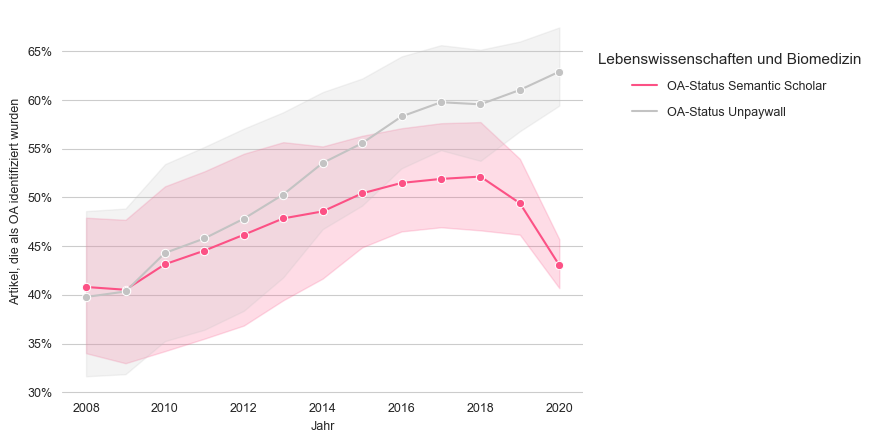

In [39]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=life_bio_sciences_s2_df[life_bio_sciences_s2_df.s2_oa_status == True],
             x='year',
             y='proportion',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=life_bio_sciences_upw_df[life_bio_sciences_upw_df.upw_oa_status == True],
             x='year',
             y='proportion',
             color='#c3c3c3',
             marker='o',
             ax=ax)

xticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(xticks)
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Artikel, die als OA identifiziert wurden')

s2_patch = Line2D([0], [0], color='#fc5185', label='OA-Status Semantic Scholar')
upw_patch = Line2D([0], [0], color='#c3c3c3', label='OA-Status Unpaywall')

lgd = fig.legend(title='Lebenswissenschaften und Biomedizin',
                 title_fontproperties={'weight': 'normal', 'size': 11},
                 handles=[s2_patch, upw_patch], frameon=False,
                 bbox_to_anchor=(1.46, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_life_bio_sciences.png', format='png', bbox_inches='tight', dpi=500)

## Arts & Humanities OA Status

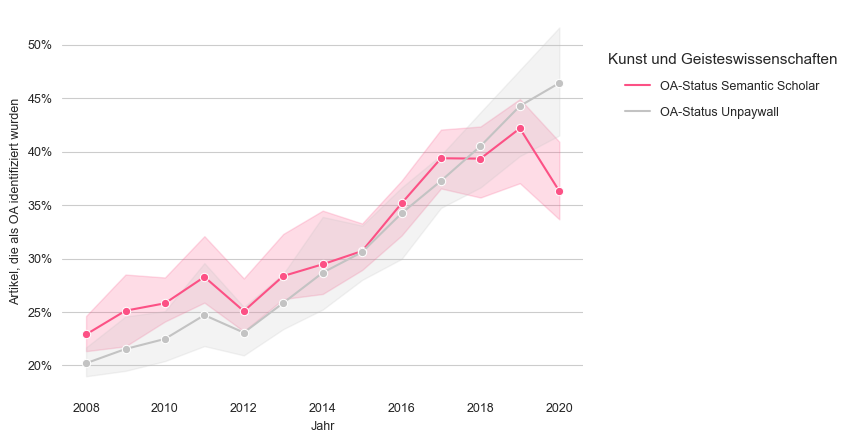

In [44]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=art_humanities_sciences_s2_df[art_humanities_sciences_s2_df.s2_oa_status == True],
             x='year',
             y='proportion',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=art_humanities_sciences_upw_df[art_humanities_sciences_upw_df.upw_oa_status == True],
             x='year',
             y='proportion',
             color='#c3c3c3',
             marker='o',
             ax=ax)

xticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(xticks)
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Artikel, die als OA identifiziert wurden')

s2_patch = Line2D([0], [0], color='#fc5185', label='OA-Status Semantic Scholar')
upw_patch = Line2D([0], [0], color='#c3c3c3', label='OA-Status Unpaywall')

lgd = fig.legend(title='Kunst und Geisteswissenschaften',
                 title_fontproperties={'weight': 'normal', 'size': 11},
                 handles=[s2_patch, upw_patch], frameon=False,
                 bbox_to_anchor=(1.42, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_art_humanities_sciences.png', format='png', bbox_inches='tight', dpi=500)

## Physical Sciences OA Status

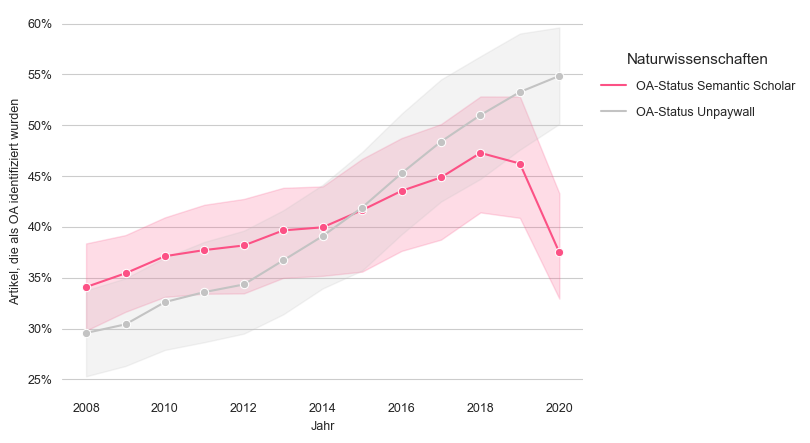

In [41]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=physical_sciences_s2_df[physical_sciences_s2_df.s2_oa_status == True],
             x='year',
             y='proportion',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=physical_sciences_upw_df[physical_sciences_upw_df.upw_oa_status == True],
             x='year',
             y='proportion',
             color='#c3c3c3',
             marker='o',
             ax=ax)

xticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(xticks)
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Artikel, die als OA identifiziert wurden')

s2_patch = Line2D([0], [0], color='#fc5185', label='OA-Status Semantic Scholar')
upw_patch = Line2D([0], [0], color='#c3c3c3', label='OA-Status Unpaywall')

lgd = fig.legend(title='Naturwissenschaften',
                 title_fontproperties={'weight': 'normal', 'size': 11},
                 handles=[s2_patch, upw_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_physical_sciences.png', format='png', bbox_inches='tight', dpi=500)

## Social Sciences OA Status

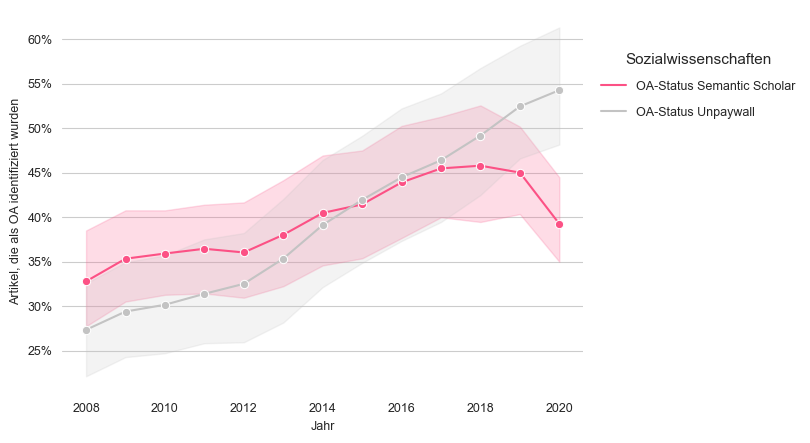

In [42]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=social_sciences_s2_df[social_sciences_s2_df.s2_oa_status == True],
             x='year',
             y='proportion',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=social_sciences_upw_df[social_sciences_upw_df.upw_oa_status == True],
             x='year',
             y='proportion',
             color='#c3c3c3',
             marker='o',
             ax=ax)

xticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(xticks)
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Artikel, die als OA identifiziert wurden')

s2_patch = Line2D([0], [0], color='#fc5185', label='OA-Status Semantic Scholar')
upw_patch = Line2D([0], [0], color='#c3c3c3', label='OA-Status Unpaywall')

lgd = fig.legend(title='Sozialwissenschaften',
                 title_fontproperties={'weight': 'normal', 'size': 11},
                 handles=[s2_patch, upw_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_social_sciences.png', format='png', bbox_inches='tight', dpi=500)

## mosaic plot

In [156]:
df_oa_disc_mosaic = client.query(f"""
                                  SELECT DISTINCT doi, category, isopenaccess
                                  FROM (
                                      SELECT DISTINCT externalids.DOI as doi, isopenaccess,
                                             EXTRACT (YEAR FROM publicationdate) AS year,
                                             field.category AS category
                                      FROM {s2ag_papers}, UNNEST(publicationtypes) as type,
                                        UNNEST(s2fieldsofstudy) as field 
                                      WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                          AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                      )
                                  WHERE year IS NOT NULL
                                  """).to_dataframe()

In [157]:
df_oa_disc_mosaic['isopenaccess'] = df_oa_disc_mosaic['isopenaccess'].astype(str)

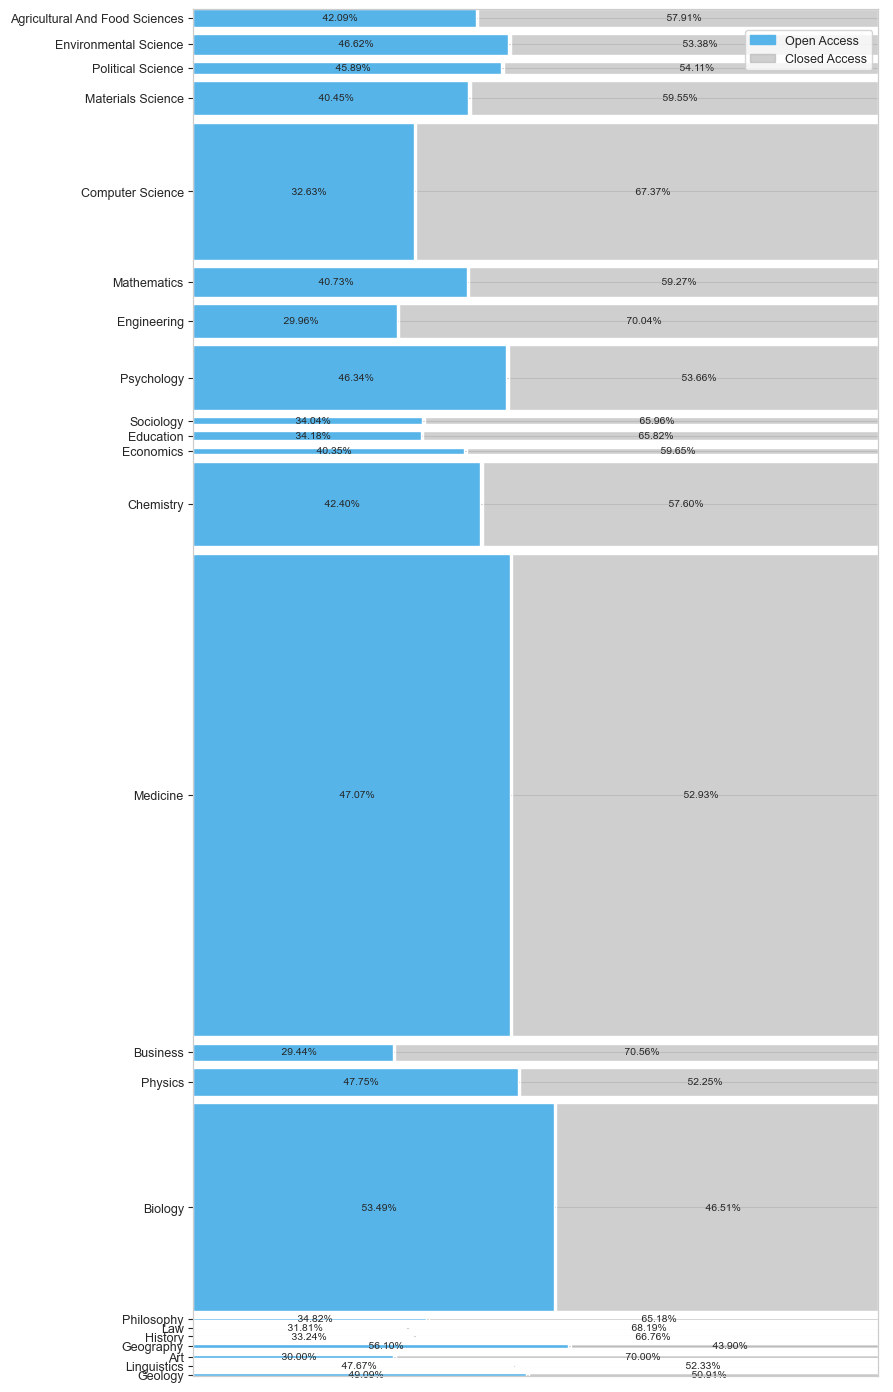

In [227]:
fig, ax = plt.subplots(figsize=(9, 14))

disc_list = life_bio_sciences + physical_sciences + social_sciences + art_humanities_sciences

label_dict = df_oa_disc_s2_table[['category', 's2_oa_status', 'oa_proportion']].copy()
label_dict['s2_oa_status'] = label_dict['s2_oa_status'].astype(str)

props = {}
for disc in disc_list:
    props[(disc, 'True')] = {'facecolor': '#56B4E9'}
    props[(disc, 'False')] = {'facecolor': '#b3b3b3a0'}

labelizer = lambda key: '    ' + label_dict.set_index(['category', 's2_oa_status']).to_dict()['oa_proportion']\
                                                               [key] + '%'

p = mosaic(df_oa_disc_mosaic, 
           ['category', 'isopenaccess'],
           title='',
           horizontal=False,
           labelizer=labelizer,
           properties=props,
           gap=0.006,
           statistic=True,
           ax=ax)

plt.axis('off')

oa_patch = mpatches.Patch(color='#56B4E9', label='Open Access')
not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='Closed Access')

lgd = fig.legend(handles=[oa_patch, not_oa_patch], frameon=True, bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()

plt.show()
fig.savefig('media/oa_status_disc.png', format='png', bbox_inches='tight', dpi=500)

## Semantic Scholar API OA-Kategorien

In [11]:
s2_sample = client.query(f"""
                          SELECT DISTINCT doi
                          FROM (
                              SELECT DISTINCT externalids.DOI as doi,
                                     EXTRACT (YEAR FROM publicationdate) AS year,
                                     field.category AS category
                              FROM {s2ag_papers}, UNNEST(publicationtypes) as type,
                                UNNEST(s2fieldsofstudy) as field 
                              WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                  AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                              )
                          WHERE year IS NOT NULL AND doi is NOT NULL
                          LIMIT 5000
                          """).to_dataframe()

In [223]:
%%script false --no-raise-error

s2 = SemanticScholar(api_key=os.environ['s2_key'])
doi_list = s2_sample.doi.tolist()
d = {
    'doi': [],
    'url': [], 
    'status': [], 
    'venue': [],
    'year': []
}
for i in range(0, len(doi_list), 20):
    try:
        results = s2.get_papers(doi_list[i:i+20])
        for result in results:
            if result.openAccessPdf is not None:
                d['url'].append(result.openAccessPdf['url'])
                d['status'].append(result.openAccessPdf['status'])
            else:
                d['url'].append(None)
                d['status'].append(None)
            d['doi'].append(result.externalIds['DOI'])
            d['venue'].append(result.venue)
            d['year'].append(result.year)
    except:
        print(doi_list[i:i+20])
        
df_oa_cat = pd.DataFrame.from_dict(d)
df_oa_cat.status.fillna(value='CLOSED', inplace=True)
df_oa_cat = df_oa_cat[df_oa_cat.year >= 2008]

In [12]:
#df_oa_cat.to_csv('sample.csv', index=False)
df_oa_cat = pd.read_csv('sample.csv')

In [13]:
df_oa_cat

,doi,url,status,venue,year
0,10.1177/0014524608096271,NaN,CLOSED,NaN,2008
1,10.3389/fimmu.2018.02826,https://www.frontiersin.org/articles/10.3389/f...,GOLD,Frontiers in Immunology,2018
2,10.1113/jphysiol.2008.154567,https://physoc.onlinelibrary.wiley.com/doi/pdf...,BRONZE,Journal of Physiology,2008
3,10.1016/j.bbabio.2014.11.012,NaN,CLOSED,Biochimica et Biophysica Acta,2015
4,10.1007/s00424-008-0527-0,NaN,CLOSED,Pflügers Archiv: European Journal of Physiology,2008
...,...,...,...,...,...
4995,10.1093/ejcts/ezt392,https://academic.oup.com/ejcts/article-pdf/45/...,BRONZE,European Journal of Cardio-Thoracic Surgery,2014
4996,10.1080/10286020.2018.1454437,NaN,CLOSED,Journal of Asian natural products research,2018
4997,10.1016/j.chroma.2008.04.017,NaN,CLOSED,Journal of Chromatography A,2008
4998,10.1007/s11625-015-0350-4,https://link.springer.com/content/pdf/10.1007%...,HYBRID,Sustainability Science,2015


In [14]:
df_oa_cat_url = df_oa_cat[df_oa_cat.status != 'CLOSED'].copy()
df_oa_cat_url['hostname'] = df_oa_cat_url['url'].apply(lambda x: urlparse(x).hostname)
df_oa_cat_url

,doi,url,status,venue,year,hostname
1,10.3389/fimmu.2018.02826,https://www.frontiersin.org/articles/10.3389/f...,GOLD,Frontiers in Immunology,2018,www.frontiersin.org
2,10.1113/jphysiol.2008.154567,https://physoc.onlinelibrary.wiley.com/doi/pdf...,BRONZE,Journal of Physiology,2008,physoc.onlinelibrary.wiley.com
5,10.1016/j.pain.2013.04.004,https://dukespace.lib.duke.edu/dspace/bitstrea...,GREEN,Pain,2013,dukespace.lib.duke.edu
7,10.1101/2022.05.07.491039,http://www.cell.com/article/S0006349518342176/pdf,BRONZE,bioRxiv,2019,www.cell.com
9,10.1371/journal.pone.0066456,https://journals.plos.org/plosone/article/file...,GOLD,PLoS ONE,2013,journals.plos.org
...,...,...,...,...,...,...
4985,10.1098/rsif.2018.0377,https://royalsocietypublishing.org/doi/pdf/10....,BRONZE,Journal of the Royal Society Interface,2018,royalsocietypublishing.org
4990,10.1093/jncics/pkaa083,https://academic.oup.com/jncics/article-pdf/5/...,GOLD,JNCI Cancer Spectrum,2020,academic.oup.com
4993,10.1016/j.jhsa.2020.01.007,http://www.jhandsurg.org/article/S036350232030...,BRONZE,Journal of Hand Surgery-American Volume,2020,www.jhandsurg.org
4995,10.1093/ejcts/ezt392,https://academic.oup.com/ejcts/article-pdf/45/...,BRONZE,European Journal of Cardio-Thoracic Surgery,2014,academic.oup.com


In [15]:
df_oa_cat_url.groupby(['hostname'])['doi'].count().reset_index().sort_values(by=['doi'], ascending=False).head(50)

,hostname,doi
137,europepmc.org,297
467,www.mdpi.com,97
472,www.nature.com,92
3,academic.oup.com,88
213,journals.plos.org,85
261,onlinelibrary.wiley.com,78
21,arxiv.org,74
229,link.springer.com,69
424,www.frontiersin.org,57
214,journals.sagepub.com,38


In [16]:
df_oa_cat_url.groupby(['hostname', 'status'])['doi'].count().reset_index().sort_values(by=['doi'], 
                                                                                       ascending=False).head(50)

,hostname,status,doi
144,europepmc.org,GREEN,297
510,www.mdpi.com,GOLD,97
225,journals.plos.org,GOLD,84
25,arxiv.org,GREEN,72
516,www.nature.com,GOLD,65
3,academic.oup.com,BRONZE,58
462,www.frontiersin.org,GOLD,57
281,onlinelibrary.wiley.com,BRONZE,46
113,downloads.hindawi.com,GOLD,36
244,link.springer.com,BRONZE,32


In [17]:
df_oa_cat_url[df_oa_cat_url.status == 'GREEN'].groupby(['hostname'])['doi'].count().reset_index()\
                                                        .sort_values(by=['doi'], ascending=False).head(50)

,hostname,doi
43,europepmc.org,297
3,arxiv.org,72
49,hal.archives-ouvertes.fr,15
44,figshare.com,11
50,hal.inria.fr,9
33,eprints.qut.edu.au,6
183,www.zora.uzh.ch,5
126,repository.tudelft.nl,5
177,www.pure.ed.ac.uk,5
23,dr.ntu.edu.sg,5


In [18]:
df_oa_cat.url.count()

2076

In [19]:
df_oa_cat.status.value_counts()

CLOSED    2924
GOLD       776
GREEN      663
BRONZE     455
HYBRID     182
Name: status, dtype: int64

In [20]:
776 + 663 + 455 + 182

2076

In [21]:
df_oa_cat.groupby(['status'])['doi'].count().reset_index()

,status,doi
0,BRONZE,455
1,CLOSED,2924
2,GOLD,776
3,GREEN,663
4,HYBRID,182


In [22]:
(455/len(df_oa_cat)) * 100

9.1

In [23]:
(776/len(df_oa_cat)) * 100

15.52

In [24]:
(663/len(df_oa_cat)) * 100

13.26

In [25]:
(182/len(df_oa_cat)) * 100

3.64

In [26]:
df_oa_cat_plot = df_oa_cat.groupby(['year', 'status'])['doi'].count().reset_index()
df_oa_cat_plot.rename(columns={'doi': 'number_of_publications'}, inplace=True)

In [27]:
df_oa_cat_plot_total = df_oa_cat.groupby(['year'])['doi'].count().reset_index()
df_oa_cat_plot_total.rename(columns={'doi': 'number_of_total_publications'}, inplace=True)
df_oa_cat_plot = pd.merge(df_oa_cat_plot, df_oa_cat_plot_total, on='year')
df_oa_cat_plot['proportion'] = (df_oa_cat_plot['number_of_publications']/\
                                df_oa_cat_plot['number_of_total_publications']) * 100
df_oa_cat_plot['status'] = df_oa_cat_plot['status'].str.lower()

In [28]:
df_oa_cat_plot = df_oa_cat_plot[df_oa_cat_plot.status != 'closed']

In [29]:
df_oa_status_upw = client.query(f"""
                                 SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications, 
                                        s2ag.year as year, upw.oa_status as oa_status
                                 FROM (
                                     SELECT DISTINCT externalids.DOI as doi,
                                            EXTRACT (YEAR FROM publicationdate) AS year
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type,
                                         UNNEST(s2fieldsofstudy) as field 
                                     WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                         AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                     ) AS s2ag
                                 INNER JOIN {upw_snapshot} AS upw
                                 ON LOWER(s2ag.doi) = LOWER(upw.doi)
                                 WHERE s2ag.year IS NOT NULL
                                 GROUP BY year, oa_status
                                 ORDER BY year, oa_status, number_of_publications DESC
                                 """).to_dataframe()

In [30]:
df_oa_status_upw.groupby(['oa_status'])['number_of_publications'].sum().reset_index()

,oa_status,number_of_publications
0,bronze,1509389
1,closed,7172371
2,gold,2636223
3,green,1869489
4,hybrid,682923


In [31]:
df_oa_status_upw.number_of_publications.sum()

13870395

In [32]:
(1509389/df_oa_status_upw.number_of_publications.sum()) * 100

10.88209095703475

In [33]:
(2636223/df_oa_status_upw.number_of_publications.sum()) * 100

19.006113380332714

In [34]:
(1869489/df_oa_status_upw.number_of_publications.sum()) * 100

13.478267922434798

In [35]:
(682923/df_oa_status_upw.number_of_publications.sum()) * 100

4.923601671041092

In [36]:
df_oa_status_upw_total = df_oa_status_upw.groupby(['year'])['number_of_publications'].sum().reset_index()
df_oa_status_upw_total.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)
df_oa_status_upw = pd.merge(df_oa_status_upw, df_oa_status_upw_total, on='year')
df_oa_status_upw['proportion'] = (df_oa_status_upw['number_of_publications']/\
                                df_oa_status_upw['number_of_total_publications']) * 100

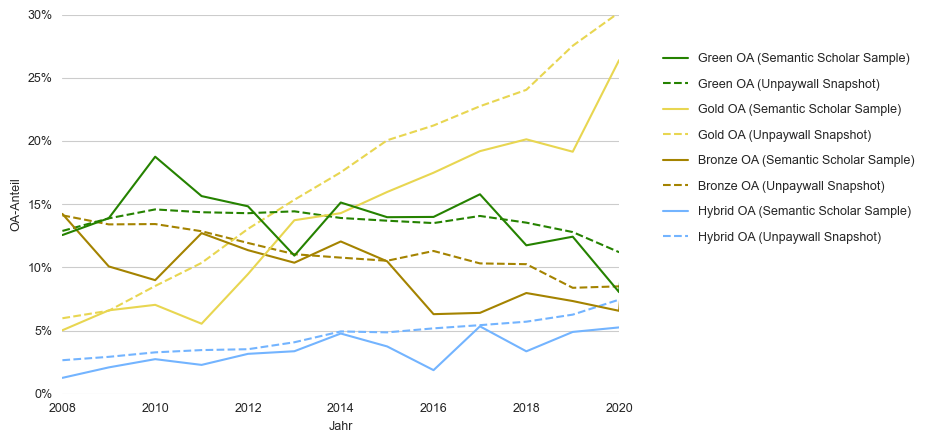

In [38]:
fig, ax = plt.subplots(figsize=(6.5,4.5))
plt.box(False)

palette = {'bronze': '#a48300',
           'gold': '#e8d651',
           'hybrid': '#73b4ff',
           'green': '#258200',
           'closed': '#410c4c'}

sns.lineplot(data=df_oa_status_upw[df_oa_status_upw.oa_status != 'closed'],
             x='year',
             y='proportion',
             hue='oa_status',
             linestyle='dashed',
             palette=palette,
             ax=ax)

sns.lineplot(data=df_oa_cat_plot,
             x='year',
             y='proportion',
             hue='status',
             palette=palette,
             ax=ax)

ax.set_xlim(2008, 2020)
ax.set_ylim(0, 30)
ax.get_legend().remove()
ax.grid(False, which='both', axis='x')
yticks = mtick.FormatStrFormatter('%.0f%%')
ax.yaxis.set_major_formatter(yticks)

plt.xlabel('Jahr')
plt.ylabel('OA-Anteil')

green_oa_patch = Line2D([0], [0], color='#258200', label='Green OA (Unpaywall Snapshot)', linestyle='dashed')
green_oa_s2_patch = Line2D([0], [0], color='#258200', label='Green OA (Semantic Scholar Sample)')
gold_oa_patch = Line2D([0], [0], color='#e8d651', label='Gold OA (Unpaywall Snapshot)', linestyle='dashed')
gold_oa_s2_patch = Line2D([0], [0], color='#e8d651', label='Gold OA (Semantic Scholar Sample)')
bronze_oa_patch = Line2D([0], [0], color='#a48300', label='Bronze OA (Unpaywall Snapshot)', linestyle='dashed')
bronze_oa_s2_patch = Line2D([0], [0], color='#a48300', label='Bronze OA (Semantic Scholar Sample)')
hybrid_oa_patch = Line2D([0], [0], color='#73b4ff', label='Hybrid OA (Unpaywall Snapshot)', linestyle='dashed')
hybrid_oa_s2_patch = Line2D([0], [0], color='#73b4ff', label='Hybrid OA (Semantic Scholar Sample)')
lgd = fig.legend(handles=[green_oa_s2_patch, green_oa_patch, 
                          gold_oa_s2_patch, gold_oa_patch, 
                          bronze_oa_s2_patch, bronze_oa_patch,
                          hybrid_oa_s2_patch, hybrid_oa_patch], frameon=False,
                 bbox_to_anchor=(1.43, 0.9), labelspacing=1.05)

plt.tight_layout()
plt.show()
fig.savefig('media/oa_status_upw_s2_comparison.png', format='png', bbox_inches='tight', dpi=500)

## Semantic Scholar im Vergleich zu anderen Datenbanken

In [42]:
df_s2_pub_num = client.query(f"""
                              SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications
                              FROM (
                                  SELECT DISTINCT externalids.DOI as doi,
                                         EXTRACT (YEAR FROM publicationdate) AS year
                                  FROM {s2ag_papers}, UNNEST(publicationtypes) as type
                                  WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                      AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                  ) AS s2ag
                              WHERE s2ag.year IS NOT NULL
                              """).to_dataframe()

In [43]:
df_s2_pub_num

,number_of_publications
0,14323019


In [9]:
df_s2_upw_pub_num = client.query(f"""
                                  SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications
                                  FROM (
                                      SELECT DISTINCT externalids.DOI as doi,
                                             EXTRACT (YEAR FROM publicationdate) AS year
                                      FROM {s2ag_papers}, UNNEST(publicationtypes) as type
                                      WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                          AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                      ) AS s2ag
                                  INNER JOIN {upw_snapshot} AS upw
                                  ON LOWER(s2ag.doi) = LOWER(upw.doi)
                                  WHERE s2ag.year IS NOT NULL
                                  """).to_dataframe()

In [10]:
df_upw_pub_num = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS number_of_publications
                               FROM {upw_snapshot}
                               WHERE year >= 2008 AND year <= 2020 AND genre = "journal-article"
                                   AND is_paratext = False
                               """).to_dataframe()

In [11]:
df_s2_upw_pub_num['number_of_publications'].iloc[0]/df_s2_pub_num['number_of_publications'].iloc[0]

0.9798196874555567

In [12]:
subsets = (df_s2_pub_num['number_of_publications'].iloc[0]-df_s2_upw_pub_num['number_of_publications'].iloc[0],
           df_upw_pub_num['number_of_publications'].iloc[0] - df_s2_upw_pub_num['number_of_publications'].iloc[0],
           df_s2_upw_pub_num['number_of_publications'].iloc[0]
          )

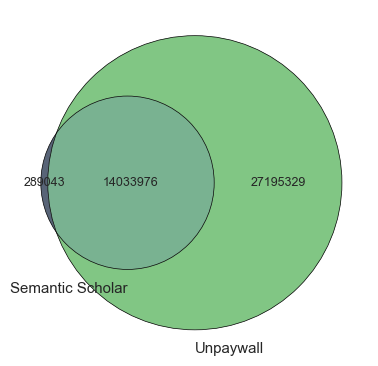

In [13]:
fig, ax = plt.subplots(figsize=(6,4.5))

venn2(subsets=subsets, 
      set_labels=('Semantic Scholar', 'Unpaywall'),
      set_colors=('#11223d', '#4caf50'),
      alpha=0.7)

venn2_circles(subsets=subsets,
              linewidth=0.5)
plt.show()
fig.savefig('media/upw_s2_comparison.png', format='png', bbox_inches='tight', dpi=500)

In [14]:
df_s2_openalex_pub_num = client.query(f"""
                                       SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications
                                       FROM (
                                           SELECT DISTINCT externalids.DOI as doi,
                                                  EXTRACT (YEAR FROM publicationdate) AS year
                                           FROM {s2ag_papers}, UNNEST(publicationtypes) as type
                                           WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                               AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                           ) AS s2ag
                                       INNER JOIN {openalex_snapshot} AS openalex
                                       ON LOWER(s2ag.doi) = LOWER(openalex.doi)
                                       WHERE s2ag.year IS NOT NULL
                                       """).to_dataframe()

In [15]:
df_openalex_pub_num = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS number_of_publications
                                    FROM {openalex_snapshot}
                                    WHERE publication_year >= 2008 AND publication_year <= 2020 
                                        AND type = "journal-article"
                                        AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                    """).to_dataframe()

In [16]:
df_s2_openalex_pub_num['number_of_publications'].iloc[0]/df_s2_pub_num['number_of_publications'].iloc[0]

0.9958768469133498

In [17]:
subsets = (df_s2_pub_num['number_of_publications'].iloc[0]-df_s2_openalex_pub_num['number_of_publications'].iloc[0],
           df_openalex_pub_num['number_of_publications'].iloc[0] - df_s2_openalex_pub_num['number_of_publications'].iloc[0],
           df_s2_openalex_pub_num['number_of_publications'].iloc[0]
          )

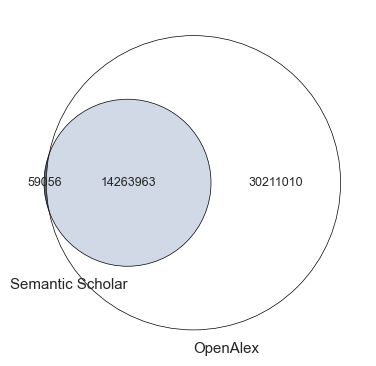

In [18]:
fig, ax = plt.subplots(figsize=(6,4.5))

venn2(subsets=subsets, 
      set_labels=('Semantic Scholar', 'OpenAlex'),
      set_colors=('#11223d', 'white'),
      alpha=0.7)

venn2_circles(subsets=subsets,
              linewidth=0.5)
plt.show()
fig.savefig('media/openalex_s2_comparison.png', format='png', bbox_inches='tight', dpi=500)

In [19]:
df_s2_cr_pub_num = client.query(f"""
                                 SELECT COUNT(DISTINCT(s2ag.doi)) AS number_of_publications
                                 FROM (
                                     SELECT DISTINCT externalids.DOI as doi,
                                            EXTRACT (YEAR FROM publicationdate) AS year
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type
                                     WHERE type = "JournalArticle" AND year >= 2008 AND year <= 2020
                                         AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                     ) AS s2ag
                                 INNER JOIN {crossref_snapshot} AS cr
                                 ON LOWER(s2ag.doi) = LOWER(cr.doi)
                                 WHERE s2ag.year IS NOT NULL
                                 """).to_dataframe()

In [20]:
df_cr_pub_num = client.query(f"""
                              SELECT COUNT(DISTINCT(doi)) AS number_of_publications
                              FROM {crossref_snapshot}
                              WHERE issued >= "2008-01-01" AND issued < "2021-01-01"
                                  AND type = "journal-article"
                                  AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                              """).to_dataframe()

In [21]:
df_s2_cr_pub_num['number_of_publications'].iloc[0]/df_s2_pub_num['number_of_publications'].iloc[0]

0.6161904134875476

In [22]:
subsets = (df_s2_pub_num['number_of_publications'].iloc[0]-df_s2_cr_pub_num['number_of_publications'].iloc[0],
           df_cr_pub_num['number_of_publications'].iloc[0]-df_s2_cr_pub_num['number_of_publications'].iloc[0],
           df_s2_cr_pub_num['number_of_publications'].iloc[0],
          )

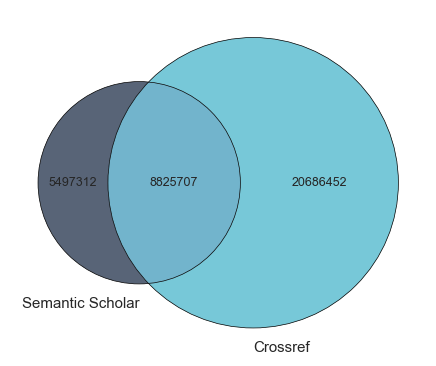

In [23]:
fig, ax = plt.subplots(figsize=(6,4.5))

venn2(subsets=subsets, 
      set_labels=('Semantic Scholar', 'Crossref'),
      set_colors=('#11223d', '#3EB1C8'),
      alpha=0.7)

venn2_circles(subsets=subsets,
              linewidth=0.5)
plt.show()
fig.savefig('media/crossref_s2_comparison.png', format='png', bbox_inches='tight', dpi=500)

In [37]:
# WoS DOI-Export
df_s2_wos_sql = """
SELECT DISTINCT externalids.DOI as doi
FROM `subugoe-wag-closed.S2AG.papers_2023_05_23`, UNNEST(publicationtypes) as type
WHERE type = "JournalArticle" AND publicationdate >= '2008-01-01' 
    AND publicationdate < '2021-01-01' AND publicationdate IS NOT NULL
    AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
"""

In [44]:
df_s2_wos_num = 7590923

In [45]:
df_wos_pub_num = 17568293

In [46]:
df_s2_wos_num/df_s2_pub_num['number_of_publications'].iloc[0]

0.529980655614574

In [47]:
subsets = (df_s2_pub_num['number_of_publications'].iloc[0]-df_s2_wos_num,
           df_wos_pub_num-df_s2_wos_num,
           df_s2_wos_num,
          )

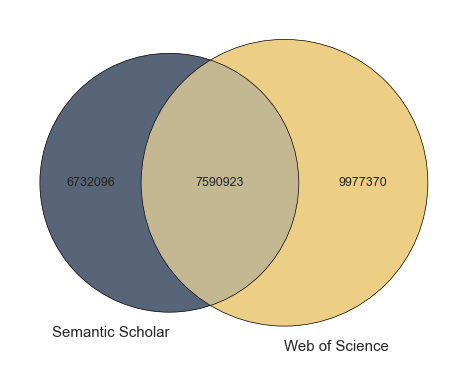

In [48]:
fig, ax = plt.subplots(figsize=(6,4.5))

venn2(subsets=subsets, 
      set_labels=('Semantic Scholar', 'Web of Science'),
      set_colors=('#11223d', '#E5BA52'),
      alpha=0.7)

venn2_circles(subsets=subsets,
              linewidth=0.5)
plt.show()
fig.savefig('media/wos_s2_comparison.png', format='png', bbox_inches='tight', dpi=500)

## Zitationsanalyse

In [5]:
df_fields_citation = client.query(f"""
                                   SELECT DISTINCT field.category AS category, isopenaccess,
                                          SUM(citationcount) AS citationcount_sum, 
                                          AVG(citationcount) AS citationcount_avg
                                   FROM {s2ag_papers}, UNNEST(publicationtypes) as type, 
                                        UNNEST(s2fieldsofstudy) as field 
                                   WHERE type = "JournalArticle" AND publicationdate >= '2008-01-01' 
                                       AND publicationdate < '2021-01-01' AND publicationdate IS NOT NULL
                                       AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                   GROUP BY category, isopenaccess
                                   ORDER BY category, isopenaccess DESC
                                   """).to_dataframe()

In [6]:
df_fields_citation_total = client.query(f"""
                                         SELECT DISTINCT field.category AS category, 
                                                SUM(citationcount) AS citationcount_sum_total, 
                                                AVG(citationcount) AS citationcount_avg_total
                                         FROM {s2ag_papers}, UNNEST(publicationtypes) as type, 
                                              UNNEST(s2fieldsofstudy) as field 
                                         WHERE type = "JournalArticle" AND publicationdate >= '2008-01-01' 
                                             AND publicationdate < '2021-01-01' AND publicationdate IS NOT NULL
                                             AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                         GROUP BY category
                                         ORDER BY category DESC
                                         """).to_dataframe()

In [7]:
df_fields_citation_year = client.query(f"""
                                        SELECT DISTINCT field.category AS category, year, isopenaccess,
                                               SUM(citationcount) AS citationcount_sum_year, 
                                               AVG(citationcount) AS citationcount_avg_year
                                        FROM {s2ag_papers}, UNNEST(publicationtypes) as type, 
                                             UNNEST(s2fieldsofstudy) as field 
                                        WHERE type = "JournalArticle" AND publicationdate >= '2008-01-01' 
                                            AND publicationdate < '2021-01-01' AND publicationdate IS NOT NULL
                                            AND NOT REGEXP_CONTAINS(title,'^Author Index$|^Back Cover|^Contents$|^Contents:|^Cover Image|^Cover Picture|^Editorial Board|^Front Cover|^Frontispiece|^Inside Back Cover|^Inside Cover|^Inside Front Cover|^Issue Information|^List of contents|^Masthead|^Title page|^Correction$|^Corrections to|^Corrections$|^Withdrawn')
                                        GROUP BY category, isopenaccess, year
                                        ORDER BY category, isopenaccess, year DESC
                                        """).to_dataframe()

In [8]:
df_fields_citation = pd.merge(df_fields_citation, df_fields_citation_total, on='category')

In [9]:
df_fields_citation

,category,isopenaccess,citationcount_sum,citationcount_avg,citationcount_sum_total,citationcount_avg_total
0,Agricultural And Food Sciences,True,5720353,34.573258,13080852,31.603895
1,Agricultural And Food Sciences,False,7360499,29.626391,13080852,31.603895
2,Art,True,351883,19.654974,858081,13.489719
3,Art,False,506198,11.074846,858081,13.489719
4,Biology,True,194444536,51.484797,296581430,42.269744
5,Biology,False,102136894,31.527012,296581430,42.269744
6,Business,True,4231941,32.831959,11646454,25.207084
7,Business,False,7414513,22.256849,11646454,25.207084
8,Chemistry,True,42862308,38.155859,97257752,34.981972
9,Chemistry,False,54395444,32.830104,97257752,34.981972


In [17]:
df_fields_citation[df_fields_citation.isopenaccess==True].citationcount_sum.sum()

757043839

In [18]:
df_fields_citation[df_fields_citation.isopenaccess==False].citationcount_sum.sum()

627242267

In [34]:
df_fields_citation_year = pd.merge(df_fields_citation_year, df_fields_citation, on=['category', 'isopenaccess'])

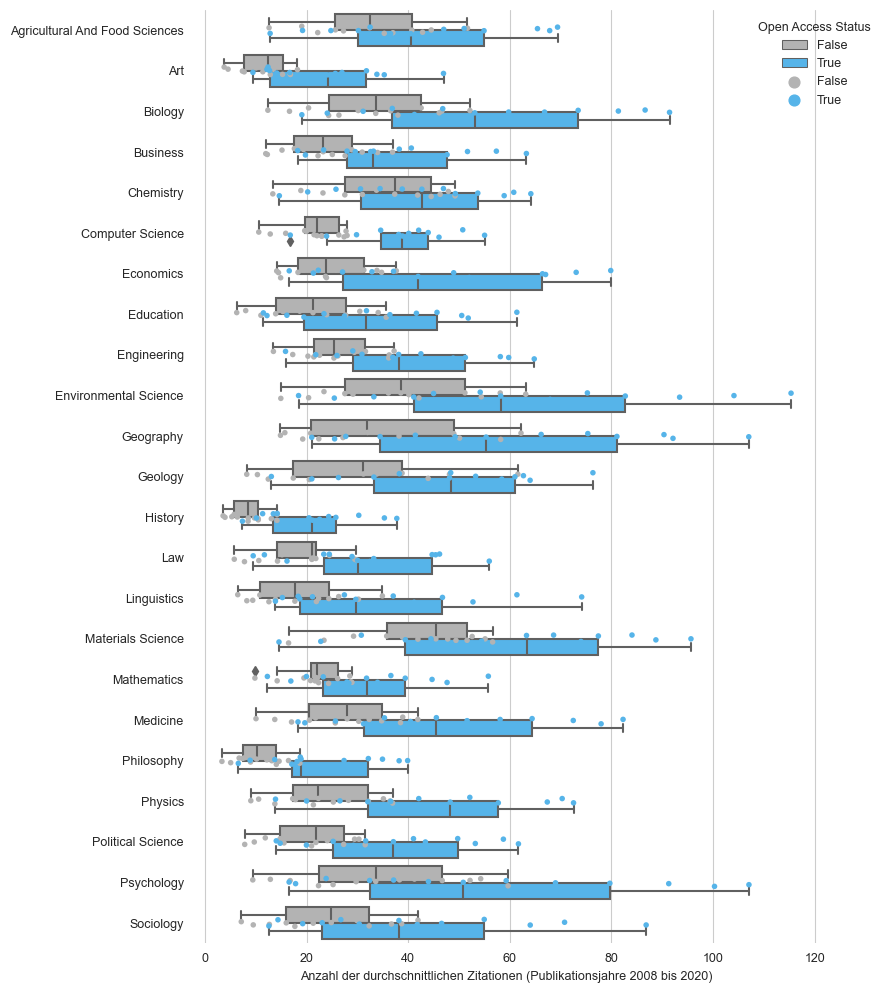

In [35]:
fig, ax = plt.subplots(figsize=(9, 10))
plt.box(False)

palette = {False: '#b3b3b3a0',
           True: '#56B4E9'}

sns.boxplot(x='citationcount_avg_year', 
            y='category', 
            hue='isopenaccess', 
            data=df_fields_citation_year,
            palette=palette,
            saturation=1,
            ax=ax)

sns.stripplot(x='citationcount_avg_year', 
              y='category', 
              hue='isopenaccess', 
              data=df_fields_citation_year,
              palette=palette,
              alpha=1,
              size=4, 
              linewidth=0,
              ax=ax)

ax.xaxis.grid(True)

plt.xlabel('Anzahl der durchschnittlichen Zitationen (Publikationsjahre 2008 bis 2020)')
plt.ylabel('')

sns.despine(trim=True, left=True)

plt.legend(title='Open Access Status', frameon=False, bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()
fig.savefig('media/s2_avg_citations_boxplot.png', format='png', bbox_inches='tight', dpi=500)

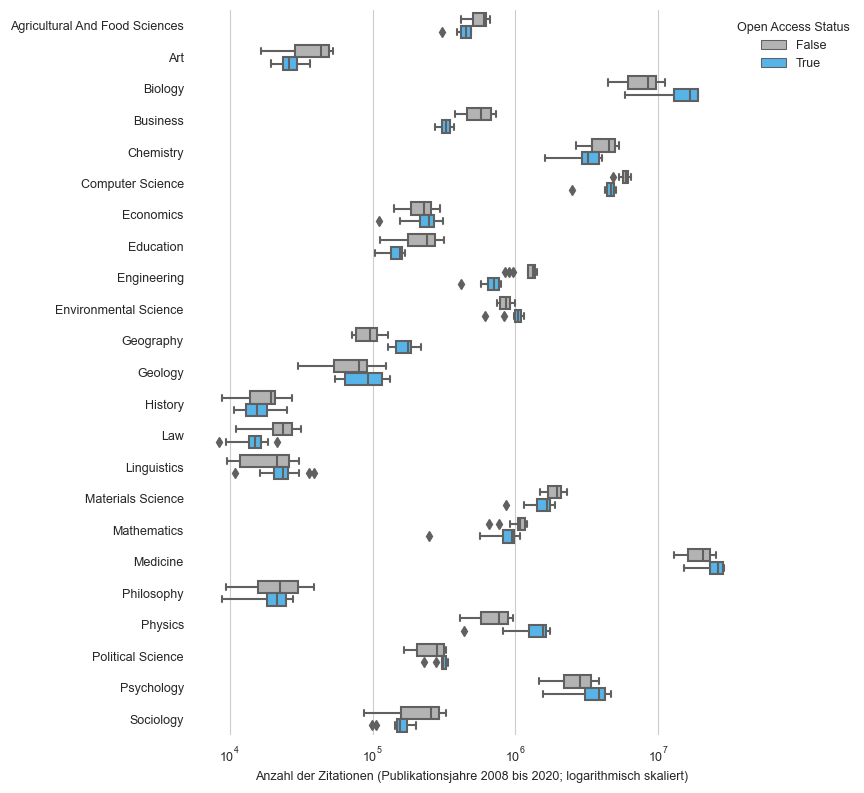

In [36]:
fig, ax = plt.subplots(figsize=(9, 8))
plt.box(False)

palette = {False: '#b3b3b3a0',
           True: '#56B4E9'}

sns.boxplot(x='citationcount_sum_year', 
            y='category', 
            hue='isopenaccess', 
            data=df_fields_citation_year,
            palette=palette,
            saturation=1,
            ax=ax)

plt.xscale('log')

plt.xlabel('Anzahl der Zitationen (Publikationsjahre 2008 bis 2020; logarithmisch skaliert)')
plt.ylabel('')

sns.despine(trim=True, left=True)

plt.legend(title='Open Access Status', frameon=False, bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()
fig.savefig('media/s2_sum_citations_boxplot.png', format='png', bbox_inches='tight', dpi=500)